# Generate homogeneous reactor data

**Credits**: This notebook was provided by **Kamila Zdybał**.

This notebook generates the homogeneous reactor data and saves it to `.csv`.

***

In [2]:
import numpy as np
import warnings
import time as time_lib
import pandas as pd
import cantera as ct
from scipy.integrate import odeint
import heapq
from scipy.interpolate import RBFInterpolator

from spitfire.chemistry import reactors
from spitfire.chemistry import mechanism
from spitfire.chemistry import flamelet
from spitfire.chemistry import tabulation
import spitfire.chemistry.analysis as sca
from spitfire.time.methods import KennedyCarpenterS6P4Q3, BackwardEulerS1P1Q1
from spitfire.time.methods import ForwardEulerS1P1, RK4ClassicalS4P4
from spitfire import odesolve
from spitfire.time.nonlinear import SimpleNewtonSolver
from spitfire.time.stepcontrol import PIController
from spitfire.chemistry.mechanism import ChemicalMechanismSpec

from cantera import gas_constant
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
from matplotlib import cm

from PCAfold import reduction

import h5py

2025-08-14 10:23:47.594483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755159828.146656   23033 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755159828.277351   23033 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def batch_reactor(chemical_mechanism, fuel_ratio, mixing_temperature, equivalence_ratio, verbose=False):
    """
    This function generates a state-space data set from a homogeneous, isochoric,
    adiabatic closed reactor.
    It uses `HomogeneousReactor` class from Spitfire.

    Input:
    ----------
    `chemical_mechanism`
               - is a chemical mechanism, object of `ChemicalMechanismSpec`.
    `fuel_ratio`
               - string specifying the mass ratios of fuel components.
    `mixing_temperature`
               - a vector of initial mixing temperatures to loop over.
    `equivalence_ratio`
               - a vector of equivalence ratios to loop over.

    Output:
    ----------
    `state_space`
               - a matrix of state space: [temperature, species mass fractions].
    `state_space_sources`
               - a matrix of state space sources:
                 [heat release rate, production rates].
    `time_list`
               - a vector of times corresponding to each row of the
                 `state_space` matrix.
    `number_of_steps`
               - list of numbers of time steps that were generated at each
                 iteration.
    `Z_stoich`
               - stoichiometric mixture fraction.
    """
    tic = time_lib.perf_counter()

    iteration = 0

    # Fuel and air streams:
    fuel = chemical_mechanism.stream('X', fuel_ratio)
    air = chemical_mechanism.stream(stp_air=True)

    Z_stoich = chemical_mechanism.stoich_mixture_fraction(fuel, air)

    species_names = chemical_mechanism.species_names
    state_space_names = np.array(['T'] + species_names)

    # Initialize matrices that will store the outputs:
    state_space = np.zeros_like(state_space_names, dtype=float)
    state_space_sources = np.zeros_like(state_space_names, dtype=float)
    time_list = np.zeros((1,))
    number_of_steps = []
    densities = dict()

    print('Integrating the homogeneous reactor...\n')

    for IC_T in mixing_temperature:

        for IC_ER in equivalence_ratio:

            # Mix fuel and oxidizer stream for the selected equivalence ratio:
            mix = chemical_mechanism.mix_for_equivalence_ratio(IC_ER, fuel, air)

            # Set the initial conditions for temperature and pressure:
            mix.TP = IC_T, 101325.

            # Intialize the homogeneous reactor and integrate:
            r = reactors.HomogeneousReactor(chemical_mechanism, 
                                            mix, 
                                            'isochoric', 
                                            'adiabatic', 
                                            'closed')
            
            output = r.integrate_to_steady_after_ignition(steady_tolerance=1.e-8, first_time_step=1.e-9, transient_tolerance=1.e-12)

            # Get the time:
            time = output.time_values
            time_list = np.hstack((time_list, time))

            # Compute how many time steps were used at this iteration:
            (n_steps, ) = np.shape(time)
            number_of_steps.append(n_steps)

            # Density:
            output = sca.compute_density(chemical_mechanism, output)
            density = output['density']
            densities[str(iteration)] = density

            # Isochoric heat capacity:
            output = sca.compute_isochoric_specific_heat(chemical_mechanism, output) # J/kg/K
            isochoric_heat_capacity = output['heat capacity cv']

            ct_sa, lib_shape = sca.get_ct_solution_array(chemical_mechanism, output)

            # Species mass fractions:
            mass_fractions = ct_sa.Y

            # Temperature:
            temperature = ct_sa.T[:,None] # K

            # Mass fractions times density:
            mass_fractions_times_density = np.multiply(ct_sa.Y, np.reshape(density, (n_steps, 1)))

            # Species production rates:
            production_rates = ct_sa.net_production_rates * ct_sa.molecular_weights
            production_rates_over_density = np.divide(production_rates, np.reshape(density, (n_steps, 1)))

            # Species enthalpies:
            species_enthalpies = ct_sa.standard_enthalpies_RT * temperature * gas_constant / ct_sa.molecular_weights[None,:] # J/kg

            # Species energies:
            species_energies = ct_sa.standard_int_energies_RT * temperature * gas_constant / ct_sa.molecular_weights[None,:] # J/kg

            # Heat release rate:
            heat_release_rate = - np.sum(production_rates * species_enthalpies, axis=1) / density.ravel() / isochoric_heat_capacity.ravel() # K/s

            if verbose == True:
                print('it.%.0f \tT: %.0f \tEquivalence ratio: %.2f \tNumber of time steps: %.0f' % (iteration, IC_T, IC_ER, n_steps))

            # Populate the solution matrices:
            state_space_at_this_iteration = np.hstack((temperature, mass_fractions))
            state_space_sources_at_this_iteration = np.hstack((np.reshape(heat_release_rate, (n_steps,1)), production_rates_over_density))

            # Append the current iteration state space to the global state space:
            state_space = np.vstack((state_space, state_space_at_this_iteration))
            state_space_sources = np.vstack((state_space_sources, state_space_sources_at_this_iteration))

            print(iteration)
            iteration += 1

    # Remove the zeros row:
    state_space = state_space[1:,:]
    state_space_sources = state_space_sources[1:,:]
    time_list = time_list[1:]

    print('\nDone!')
    
    toc = time_lib.perf_counter()
    
    print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)
    
    return (state_space, state_space_sources, time_list, number_of_steps, Z_stoich, densities)

def get_mixture_fraction_from_equivalence_ratio(equivalence_ratio, Z_stoich):
    """
    This function computes mixture fraction vector based on the equivalence
    ratio and the stoichiometric mixture fraction using:

    equivalence_ratio = Z/(1 - Z) * (1 - Z_stoich)/Z_stoich

    Input:
    ----------
    `equivalence_ratio`
               - scalar or vector of equivalence ratio(s).
    `Z_stoich` - stoichiometric mixture fraction.

    Output:
    ----------
    `Z`        - vector of mixture fractions. Each element corresponds to the
                 element in `equivalence_ratio` vector.
    """

    if np.isscalar(equivalence_ratio):

        A = equivalence_ratio * Z_stoich / (1 - Z_stoich)
        Z = A / (1+A)

    elif len(equivalence_ratio) == 1:

        equivalence_ratio = np.asscalar(np.array(equivalence_ratio))

        A = equivalence_ratio * Z_stoich / (1 - Z_stoich)
        Z = A / (1+A)

    else:

        Z = np.empty([len(equivalence_ratio), 1])

        for i in range(0, len(equivalence_ratio)):

            A = equivalence_ratio[i] * Z_stoich / (1 - Z_stoich)
            Z[i] = A / (1+A)

    return Z

def get_equivalence_ratio_from_mixture_fraction(Z, Z_stoich):
    """
    This function computes equivalence ratio vector based on the mixture
    fraction and the stoichiometric mixture fraction using:

    equivalence_ratio = Z/(1 - Z) * (1 - Z_stoich)/Z_stoich

    Input:
    ----------
    `Z`        - scalar or vector of mixture fraction(s).
    `Z_stoich` - stoichiometric mixture fraction.

    Output:
    ----------
    `equivalence_ratio`
               - vector of equivalence ratios.
    """

    if np.isscalar(Z):

        equivalence_ratio = Z/(1 - Z) * (1 - Z_stoich)/Z_stoich

    elif len(Z) == 1:

        Z = np.asscalar(np.array(Z))

        equivalence_ratio = Z/(1 - Z) * (1 - Z_stoich)/Z_stoich

    else:

        equivalence_ratio = np.empty([len(Z), 1])

        for i in range(0, len(Z)):

            equivalence_ratio[i] = Z[i]/(1 - Z[i]) * (1 - Z_stoich)/Z_stoich

    return equivalence_ratio

#### Define chemical mechanisms that we might want to use:

In [4]:
filename_prefix = 'isochoric-adiabatic-closed-HR'

In [5]:
fuel = 'H2'

In [6]:
chemical_mechanism = ChemicalMechanismSpec('chem.yaml', 'gas')
species_names = chemical_mechanism.species_names
print(species_names)

['N2', 'H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'N', 'NO', 'NH', 'NH2', 'HNO', 'H2NN', 'NO2', 'N2O', 'NNH', 'HONO', 'HONO2', 'N2H3']


In [7]:
state_space_names = chemical_mechanism.species_names
state_space_names = ['T'] + state_space_names
print(state_space_names)

['T', 'N2', 'H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'N', 'NO', 'NH', 'NH2', 'HNO', 'H2NN', 'NO2', 'N2O', 'NNH', 'HONO', 'HONO2', 'N2H3']


#### Fuel ratios:

In [8]:
h2_ratio = 'H2:1'
air = chemical_mechanism.stream(stp_air=True)
fuel = chemical_mechanism.stream('X', h2_ratio)
Z_stoich = chemical_mechanism.stoich_mixture_fraction(fuel, air)
print("Stoichiometric mixture fraction: " + str(round(Z_stoich, 5)))

Stoichiometric mixture fraction: 0.02864


In [48]:
# Vector of initial mixture temperatures:
T_init = 900   #900K
mixing_temperatures = np.array([T_init])

In [52]:
#given the values from the f-T flamelet manifold

Z_start = 0.015
Z_end = 0.035 #0.0225 

phi_start = get_equivalence_ratio_from_mixture_fraction(Z_start, Z_stoich)
phi_end = get_equivalence_ratio_from_mixture_fraction(Z_end, Z_stoich)

print(f"equivalence ratio from {np.round(phi_start,5)} to {np.round(phi_end,5)}")

equivalence ratio from 0.51657 to 1.2303


In [ ]:
nbr_steps_ratios = 100
lin_log = "lin"

if lin_log == "log":
    equivalence_ratios = np.logspace(np.log10(phi_start),np.log10(phi_end),nbr_steps_ratios)
    print(equivalence_ratios)
elif lin_log == "lin":
    equivalence_ratios = np.linspace(phi_start,phi_end,nbr_steps_ratios)
    print(equivalence_ratios)

[0.51656681 0.53113286 0.54569891 0.56026496 0.57483101 0.58939706
 0.60396311 0.61852917 0.63309522 0.64766127 0.66222732 0.67679337
 0.69135942 0.70592547 0.72049153 0.73505758 0.74962363 0.76418968
 0.77875573 0.79332178 0.80788783 0.82245389 0.83701994 0.85158599
 0.86615204 0.88071809 0.89528414 0.90985019 0.92441625 0.9389823
 0.95354835 0.9681144  0.98268045 0.9972465  1.01181255 1.0263786
 1.04094466 1.05551071 1.07007676 1.08464281 1.09920886 1.11377491
 1.12834096 1.14290702 1.15747307 1.17203912 1.18660517 1.20117122
 1.21573727 1.23030332]


In [54]:
mixture_fractions = get_mixture_fraction_from_equivalence_ratio(equivalence_ratios, Z_stoich)
mixture_fractions

array([[0.015     ],
       [0.01541645],
       [0.01583254],
       [0.01624828],
       [0.01666368],
       [0.01707872],
       [0.01749341],
       [0.01790775],
       [0.01832174],
       [0.01873538],
       [0.01914868],
       [0.01956163],
       [0.01997422],
       [0.02038648],
       [0.02079838],
       [0.02120994],
       [0.02162115],
       [0.02203202],
       [0.02244254],
       [0.02285272],
       [0.02326256],
       [0.02367205],
       [0.02408119],
       [0.02449   ],
       [0.02489846],
       [0.02530658],
       [0.02571436],
       [0.0261218 ],
       [0.0265289 ],
       [0.02693565],
       [0.02734207],
       [0.02774815],
       [0.02815389],
       [0.02855929],
       [0.02896435],
       [0.02936907],
       [0.02977346],
       [0.03017751],
       [0.03058123],
       [0.0309846 ],
       [0.03138765],
       [0.03179035],
       [0.03219273],
       [0.03259477],
       [0.03299647],
       [0.03339784],
       [0.03379888],
       [0.034

In [55]:
# Generate data set from a homogenous, isochoric, adiabatic, closed reactor:
(state_space, state_space_sources, time_list, number_of_steps, Z_stoich, densities) = batch_reactor(chemical_mechanism, h2_ratio, mixing_temperatures, equivalence_ratios)

n_observations = np.sum(number_of_steps)
print('Generated: ', np.sum(number_of_steps), 'observations.')
print("Stoichiometric mixture fraction: " + str(round(Z_stoich,3)))

equivalence_ratio_vector = []

for i, n_steps in enumerate(number_of_steps):
    single_equivalence_vector = np.repeat(equivalence_ratios[i], n_steps).tolist()
    equivalence_ratio_vector = np.concatenate((equivalence_ratio_vector, single_equivalence_vector))
    
mixture_fraction = get_mixture_fraction_from_equivalence_ratio(equivalence_ratio_vector, Z_stoich)

Integrating the homogeneous reactor...

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49

Done!
	Time it took: 1.6 minutes.
----------------------------------------
Generated:  120772 observations.
Stoichiometric mixture fraction: 0.029


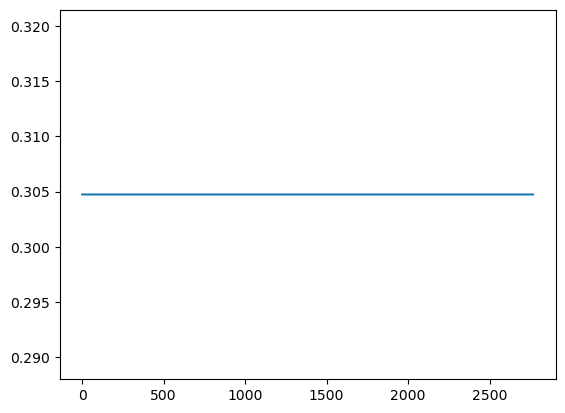

In [32]:
plt.plot(densities['8'])

Text(0, 0.5, 'Temperature')

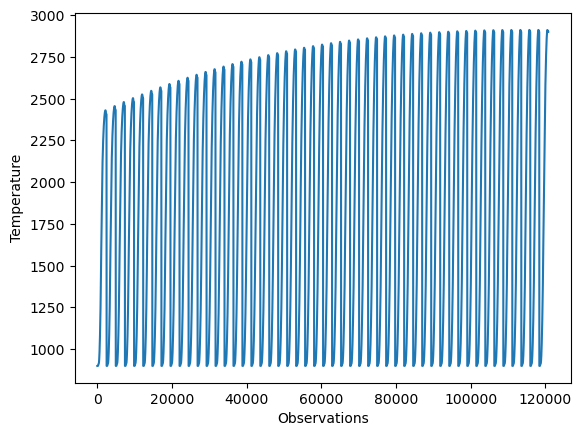

In [56]:
plt.plot(state_space[:,0])
plt.xlabel("Observations")
plt.ylabel("Temperature")

***

## Generate the associated test trajectory for *a posteriori* testing

In [62]:
# Create 10 test trajectories:
idx_test = range(5,50,5)
mixture_fractions_test = []
data_tag = f'H2-air-{lin_log}_Z_{Z_start}_{Z_end}_{nbr_steps_ratios}-T0_{T_init}'

for i, start_idx in enumerate(idx_test):
    equivalence_ratios_test = np.array([0.5*(equivalence_ratios[start_idx] + equivalence_ratios[start_idx+1])])
    (state_space_test_trajectory, state_space_sources_test_trajectory, time_list_test_trajectory, _, _, _) = batch_reactor(chemical_mechanism, h2_ratio, mixing_temperatures, equivalence_ratios_test)

    
    with h5py.File(filename_prefix + '-' + data_tag + '-state-space-test-trajectories.h5', 'a') as hf:
        hf.create_dataset(f"test_trajectory_{i}", data=state_space_test_trajectory)
    with h5py.File(filename_prefix + '-' + data_tag + '-state-space-sources-test-trajectories.h5', 'a') as hf:
        hf.create_dataset(f"test_trajectory_{i}", data=state_space_sources_test_trajectory)
    with h5py.File(filename_prefix + '-' + data_tag + '-time-test-trajectories.h5', 'a') as hf:
        hf.create_dataset(f"test_trajectory_{i}", data=time_list_test_trajectory)
    
    
    mixture_fraction_test = get_mixture_fraction_from_equivalence_ratio(equivalence_ratios_test[0]*np.ones_like(time_list_test_trajectory), Z_stoich)
    mixture_fractions_test.append(mixture_fraction_test[0,0])

Integrating the homogeneous reactor...

0

Done!
	Time it took: 0.0 minutes.
----------------------------------------
Integrating the homogeneous reactor...

0

Done!
	Time it took: 0.0 minutes.
----------------------------------------
Integrating the homogeneous reactor...

0

Done!
	Time it took: 0.0 minutes.
----------------------------------------
Integrating the homogeneous reactor...

0

Done!
	Time it took: 0.0 minutes.
----------------------------------------
Integrating the homogeneous reactor...

0

Done!
	Time it took: 0.0 minutes.
----------------------------------------
Integrating the homogeneous reactor...

0

Done!
	Time it took: 0.0 minutes.
----------------------------------------
Integrating the homogeneous reactor...

0

Done!
	Time it took: 0.0 minutes.
----------------------------------------
Integrating the homogeneous reactor...

0

Done!
	Time it took: 0.0 minutes.
----------------------------------------
Integrating the homogeneous reactor...

0

Done!
	Time i

In [59]:
mf_test = mixture_fraction_test[0,0]
mf_test

0.03359840232389253

In [60]:
equivalence_ratios[start_idx]

1.1720391190617157

In [61]:
equivalence_ratios[start_idx+1]

1.1866051704707257

***

## Generate the associated support trajectory for *a posteriori* testing

In [62]:
# Create support data near the test trajectory:
equivalence_ratios_support = np.linspace(equivalence_ratios[start_idx],equivalence_ratios[start_idx+1],20)

(state_space_support, state_space_sources_support, time_list_support, number_of_steps, _, _) = batch_reactor(chemical_mechanism, h2_ratio, mixing_temperatures, equivalence_ratios_support)

equivalence_ratio_vector = []

for i, n_steps in enumerate(number_of_steps):
    single_equivalence_vector = np.repeat(equivalence_ratios_support[i], n_steps).tolist()
    equivalence_ratio_vector = np.concatenate((equivalence_ratio_vector, single_equivalence_vector))
    
mixture_fraction_support = get_mixture_fraction_from_equivalence_ratio(equivalence_ratio_vector, Z_stoich)

Integrating the homogeneous reactor...

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19

Done!
	Time it took: 0.6 minutes.
----------------------------------------


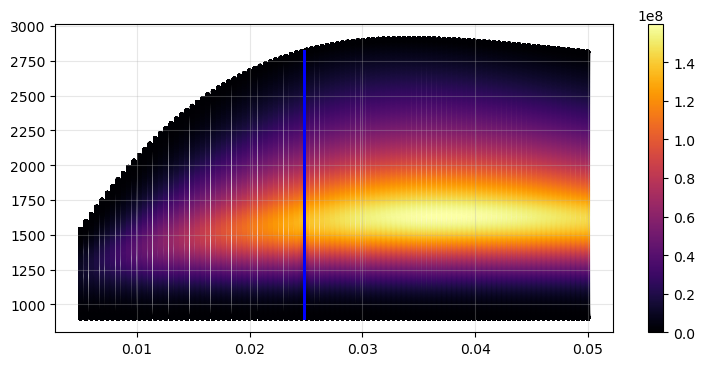

In [63]:
vmin = min(state_space_sources[:,0].min(), state_space_sources_support[:,0].min())
vmax = max(state_space_sources[:,0].max(), state_space_sources_support[:,0].max())

plt = reduction.plot_2d_manifold(mixture_fraction, state_space[:,0], color=state_space_sources[:,0], color_map='inferno', figure_size=(9,4))
plt.scatter(mixture_fraction_test, state_space_test_trajectory[:,0], color='b', s=1, zorder=100);
plt.scatter(mixture_fraction_support, state_space_support[:,0], c=state_space_sources_support[:,0], s=1, alpha=0.1, cmap='inferno', 
    vmin=vmin, 
    vmax=vmax)

In [48]:
print(f"max T source of state space is {np.round(np.max(state_space_sources[:,0]),3)}")
print(f"max T source of support state space is {np.round(np.max(state_space_sources_support[:,0]),3)}")

max T source of state space is 124295326.857
max T source of support state space is 61650587.514


***

## Save data to `.csv`:

In [63]:
data_tag = f'H2-air-{lin_log}_Z_{Z_start}_{Z_end}_{nbr_steps_ratios}-T0_{T_init}'

In [65]:
np.savetxt(filename_prefix + '-' + data_tag + '-state-space-names.csv', (state_space_names), delimiter=',', fmt="%s")

In [66]:
np.savetxt(filename_prefix + '-' + data_tag + '-state-space.csv', (state_space), delimiter=',', fmt='%.16e')
np.savetxt(filename_prefix + '-' + data_tag + '-state-space-sources.csv', (state_space_sources), delimiter=',', fmt='%.16e')
np.savetxt(filename_prefix + '-' + data_tag + '-mixture-fraction.csv', (mixture_fraction), delimiter=',', fmt='%.16e')
np.savetxt(filename_prefix + '-' + data_tag + '-time.csv', (time_list), delimiter=',', fmt='%.16e')

In [67]:
np.savetxt(filename_prefix + '-' + data_tag + '-mixture-fractions-test-trajectories.csv', (mixture_fractions_test), delimiter=',', fmt='%.16e')

In [120]:
np.savetxt(filename_prefix + '-' + data_tag + '-state-space-support-' + str(round(mf_test,3)) + '.csv', (state_space_support), delimiter=',', fmt='%.16e')
np.savetxt(filename_prefix + '-' + data_tag + '-state-space-sources-support-' + str(round(mf_test,3)) + '.csv', (state_space_sources_support), delimiter=',', fmt='%.16e')
np.savetxt(filename_prefix + '-' + data_tag + '-mixture-fraction-support-' + str(round(mf_test,3)) + '.csv', (mixture_fraction_support), delimiter=',', fmt='%.16e')
np.savetxt(filename_prefix + '-' + data_tag + '-time-support-' + str(round(mf_test,3)) + '.csv', (time_list_support), delimiter=',', fmt='%.16e')

In [121]:
np.savetxt(filename_prefix + '-' + data_tag + '-state-space-test-trajectory-' + str(round(mf_test,3)) + '.csv', (state_space_test_trajectory), delimiter=',', fmt='%.16e')
np.savetxt(filename_prefix + '-' + data_tag + '-state-space-sources-test-trajectory-' + str(round(mf_test,3)) + '.csv', (state_space_sources_test_trajectory), delimiter=',', fmt='%.16e')
np.savetxt(filename_prefix + '-' + data_tag + '-mixture-fraction-test-trajectory-' + str(round(mf_test,3)) + '.csv', (mixture_fraction_test), delimiter=',', fmt='%.16e')
np.savetxt(filename_prefix + '-' + data_tag + '-time-test-trajectory-' + str(round(mf_test,3)) + '.csv', (time_list_test_trajectory), delimiter=',', fmt='%.16e')

***